Using device: cuda
GPU: Tesla T4
CUDA version: 12.6
Loaded data: 32,332 samples, 10 features → target: PR_raw
Train: 25,865  |  Val: 3,233  |  Test: 3,234
[    1]  train total: 0.202334  (data: 0.185715 | phys: 3.32e-05)   val MSE: 0.031972   λ_daily: -9.73e-04   λ_annual(%): -35.5102
   → new best model saved  (val MSE = 0.031972)
[    2]  train total: 0.278104  (data: 0.267883 | phys: 2.04e-05)   val MSE: 0.105513   λ_daily: -5.59e-03   λ_annual(%): -203.9535
[    3]  train total: 0.269508  (data: 0.265994 | phys: 7.03e-06)   val MSE: 0.036954   λ_daily: -2.01e-03   λ_annual(%): -73.4581
[    4]  train total: 0.270711  (data: 0.264857 | phys: 1.17e-05)   val MSE: 0.114573   λ_daily: -4.51e-03   λ_annual(%): -164.6050
[    5]  train total: 0.298563  (data: 0.294036 | phys: 9.05e-06)   val MSE: 0.213568   λ_daily: -3.77e-03   λ_annual(%): -137.5040
   → new best model saved  (val MSE = 0.031878)
   → new best model saved  (val MSE = 0.031196)
   → new best model saved  (val MSE = 0.029

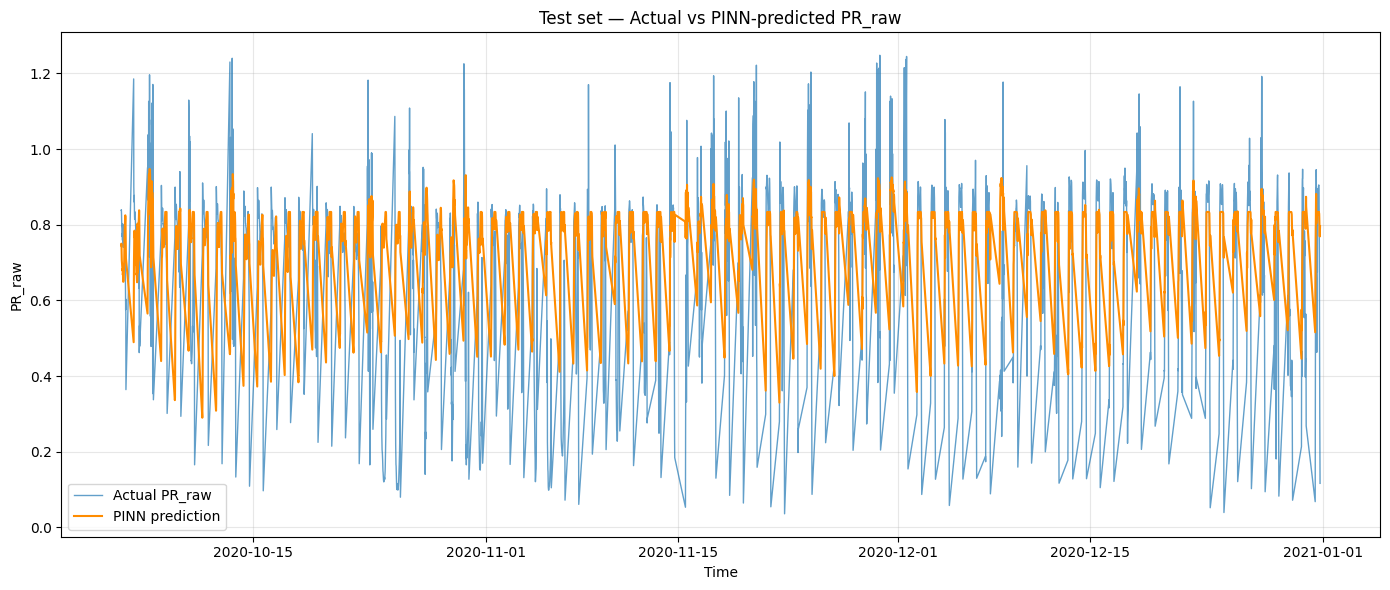


Training finished. Best model saved: best_pinn_model_pr_raw.pth


In [2]:
# solar_pinn_training_pr_raw_with_physics_cuda.py
# Trains a neural network + simple physics-informed loss to predict PR_raw
# Chronological 80/10/10 split + CUDA support

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# ────────────────────────────────────────────────
# Configuration
# ────────────────────────────────────────────────

CSV_FILE          = "prepared_solar_data_for_pinn.csv"
MODEL_SAVE_PATH   = "best_pinn_model_pr_raw.pth"

BATCH_SIZE        = 2048
EPOCHS            = 2000
LEARNING_RATE     = 3e-3
PATIENCE          = 2200

# Physics loss weight & expected degradation scale
LAMBDA_PHYS       = 500
EXPECTED_DAILY_DEG_RAD = 3e-5

# ────────────────────────────────────────────────
# Device setup (CUDA if available)
# ────────────────────────────────────────────────

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

# ────────────────────────────────────────────────
# 1. Load prepared data
# ────────────────────────────────────────────────

df = pd.read_csv(CSV_FILE, parse_dates=['timestamp'], index_col='timestamp')

input_features = [
    't_days', 'G', 'DNI', 'GHI', 'T_amb', 'pressure_hPa',
    'doy_sin', 'doy_cos', 'hour_sin', 'hour_cos'
]

target = 'PR_raw'

X = df[input_features].values.astype(np.float32)
y = df[target].values.astype(np.float32).reshape(-1, 1)

print(f"Loaded data: {X.shape[0]:,} samples, {X.shape[1]} features → target: {target}")

# ────────────────────────────────────────────────
# 2. Chronological split: 80% train / 10% val / 10% test
# ────────────────────────────────────────────────

n_total = len(X)
n_train = int(0.80 * n_total)
n_val   = int(0.10 * n_total)

X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test,  y_test  = X[n_train+n_val:], y[n_train+n_val:]

print(f"Train: {len(X_train):,}  |  Val: {len(X_val):,}  |  Test: {len(X_test):,}")

# ────────────────────────────────────────────────
# 3. Dataset & DataLoader (data stays on CPU, moved to GPU in loop)
# ────────────────────────────────────────────────

class SolarDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SolarDataset(X_train, y_train)
val_ds   = SolarDataset(X_val,   y_val)
test_ds  = SolarDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE*2, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE*2, shuffle=False, num_workers=4, pin_memory=True)

# pin_memory=True + num_workers>0 → faster data transfer to GPU

# ────────────────────────────────────────────────
# 4. Model + learnable degradation rate
# ────────────────────────────────────────────────

class SolarPINN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 96),
            nn.ReLU(),
            nn.Linear(96, 96),
            nn.ReLU(),
            nn.Linear(96, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.lambda_deg = nn.Parameter(torch.tensor(EXPECTED_DAILY_DEG_RAD))

    def forward(self, x):
        return self.net(x)

model = SolarPINN(input_dim=X.shape[1])
model = model.to(device)  # ← Move model to GPU

optimizer = optim.AdamW(
    list(model.parameters()) + [model.lambda_deg],
    lr=LEARNING_RATE,
    weight_decay=1e-5
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.4, patience=700)

criterion = nn.MSELoss()

# ────────────────────────────────────────────────
# 5. Training loop with PINN loss (CUDA optimized)
# ────────────────────────────────────────────────

best_val_loss = float('inf')
best_epoch = 0
patience_counter = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss_total = 0.0
    train_data_loss  = 0.0
    train_phys_loss  = 0.0

    for Xb, yb in train_loader:
        Xb = Xb.to(device, non_blocking=True)   # ← Move batch to GPU
        yb = yb.to(device, non_blocking=True)
        Xb.requires_grad_(True)

        optimizer.zero_grad(set_to_none=True)    # faster than zero_grad()

        PR_pred = model(Xb)

        loss_data = criterion(PR_pred, yb)

        dPR_dt = torch.autograd.grad(
            PR_pred.sum(), Xb, create_graph=True, retain_graph=True
        )[0][:, 0:1]

        loss_phys = (dPR_dt + model.lambda_deg).pow(2).mean()

        loss = loss_data + LAMBDA_PHYS * loss_phys

        loss.backward()
        optimizer.step()

        train_loss_total += loss.item() * Xb.size(0)
        train_data_loss  += loss_data.item() * Xb.size(0)
        train_phys_loss  += loss_phys.item() * Xb.size(0)

    train_loss_total /= len(train_ds)
    train_data_loss  /= len(train_ds)
    train_phys_loss  /= len(train_ds)

    # ── Validation ───────────────────────────────────
    model.eval()
    val_loss_total = 0.0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb = Xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            PR_pred = model(Xb)
            val_loss_total += criterion(PR_pred, yb).item() * Xb.size(0)

    val_loss_total /= len(val_ds)

    scheduler.step(val_loss_total)

    if epoch % 500 == 0 or epoch <= 5:
        print(f"[{epoch:5d}]  "
              f"train total: {train_loss_total:.6f}  "
              f"(data: {train_data_loss:.6f} | phys: {train_phys_loss:.2e})   "
              f"val MSE: {val_loss_total:.6f}   "
              f"λ_daily: {model.lambda_deg.item():.2e}   "
              f"λ_annual(%): {model.lambda_deg.item()*365*100:.4f}")

    if val_loss_total < best_val_loss:
        best_val_loss = val_loss_total
        best_epoch = epoch
        patience_counter = 0
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"   → new best model saved  (val MSE = {val_loss_total:.6f})")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch}  "
                  f"(best val MSE {best_val_loss:.6f} at epoch {best_epoch})")
            break

# ────────────────────────────────────────────────
# 6. Final evaluation (on GPU)
# ────────────────────────────────────────────────

model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
model.eval()

def evaluate(loader, name="set"):
    preds, truths = [], []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device, non_blocking=True)
            pred = model(Xb).cpu().numpy()
            preds.append(pred)
            truths.append(yb.numpy())
    preds = np.concatenate(preds).flatten()
    truths = np.concatenate(truths).flatten()

    mae  = mean_absolute_error(truths, preds)
    rmse = np.sqrt(mean_squared_error(truths, preds))
    print(f"\n{name.upper()} set:")
    print(f"  MAE  = {mae:.5f}")
    print(f"  RMSE = {rmse:.5f}")
    return preds, truths

print("\nFinal evaluation:")
train_preds, train_true = evaluate(train_loader, "Train")
val_preds,   val_true   = evaluate(val_loader,   "Val")
test_preds,  test_true  = evaluate(test_loader,  "Test")

print(f"\nLearned daily degradation rate   : {model.lambda_deg.item():.2e}")
print(f"Learned annual degradation rate : {model.lambda_deg.item() * 365 * 100:.4f} %/year")

# ────────────────────────────────────────────────
# 7. Plot test set predictions
# ────────────────────────────────────────────────

plt.figure(figsize=(14, 6))
plt.plot(df.index[-len(test_true):], test_true,  label='Actual PR_raw', lw=1, alpha=0.7)
plt.plot(df.index[-len(test_true):], test_preds, label='PINN prediction', lw=1.5, color='darkorange')
plt.xlabel("Time")
plt.ylabel("PR_raw")
plt.title("Test set — Actual vs PINN-predicted PR_raw")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTraining finished. Best model saved: {MODEL_SAVE_PATH}")

Using device: cuda
Model loaded successfully.
Loaded 101 samples with 10 features from Simulink CSV
Generated 101 predictions.
Predictions saved to: simulink_with_pinn_predictions.csv


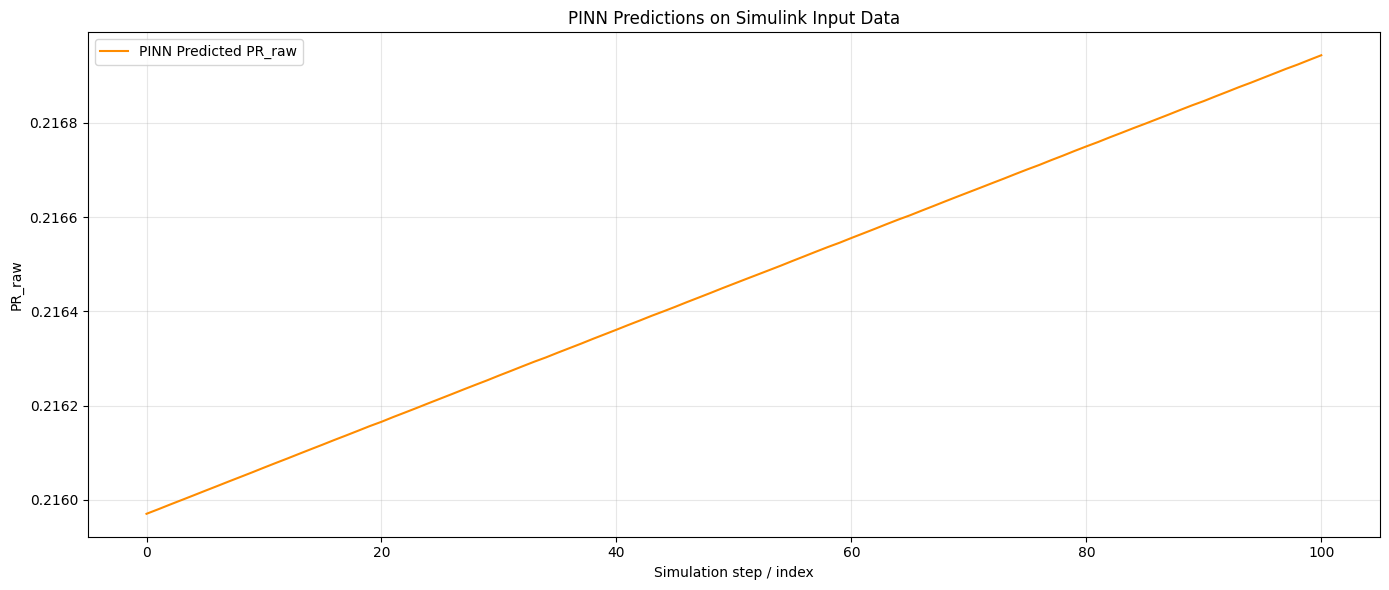


Prediction statistics:
count    101.000000
mean       0.216458
std        0.000285
min        0.215970
25%        0.216215
50%        0.216459
75%        0.216702
max        0.216944
dtype: float64

Done.


In [4]:
# simulink_inference_with_pinn.py
# Loads Simulink input log CSV → runs inference with your trained PINN model

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ────────────────────────────────────────────────
# Configuration – change these if needed
# ────────────────────────────────────────────────

INPUT_CSV       = "simulink_input_log.csv"              # your Simulink output file
MODEL_PATH      = "best_pinn_model_pr_raw.pth"          # your trained .pth file
OUTPUT_CSV      = "simulink_with_pinn_predictions.csv"  # where predictions are saved

# ────────────────────────────────────────────────
# 1. Define the exact same model architecture
# ────────────────────────────────────────────────

class SolarPINN(nn.Module):
    def __init__(self, input_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 96),
            nn.ReLU(),
            nn.Linear(96, 96),
            nn.ReLU(),
            nn.Linear(96, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        # We don't need lambda_deg for inference (it's not used in forward)
        self.lambda_deg = nn.Parameter(torch.tensor(EXPECTED_DAILY_DEG_RAD))
    def forward(self, x):
        return self.net(x)

# ────────────────────────────────────────────────
# 2. Load model
# ────────────────────────────────────────────────

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = SolarPINN(input_dim=10)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

print("Model loaded successfully.")

# ────────────────────────────────────────────────
# 3. Load Simulink CSV & prepare inputs
# ────────────────────────────────────────────────

df = pd.read_csv(INPUT_CSV)

# Check required columns
required_cols = [
    't_days', 'G_norm', 'DNI_norm', 'GHI_norm', 'T_amb_norm',
    'pressure_norm', 'doy_sin', 'doy_cos', 'hour_sin', 'hour_cos'
]

missing = [col for col in required_cols if col not in df.columns]
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")

# Extract features as NumPy array
X_sim = df[required_cols].values.astype(np.float32)

print(f"Loaded {X_sim.shape[0]} samples with {X_sim.shape[1]} features from Simulink CSV")

# ────────────────────────────────────────────────
# 4. Run inference
# ────────────────────────────────────────────────

with torch.no_grad():
    X_tensor = torch.from_numpy(X_sim).to(device)

    # If dataset is large, use batch inference (safer for memory)
    batch_size = 8192
    predictions = []

    for i in range(0, len(X_tensor), batch_size):
        batch = X_tensor[i:i+batch_size]
        pred = model(batch).cpu().numpy().flatten()
        predictions.extend(pred)

    pr_pred = np.array(predictions)

print(f"Generated {len(pr_pred)} predictions.")

# ────────────────────────────────────────────────
# 5. Save results to new CSV
# ────────────────────────────────────────────────

df_out = df.copy()
df_out['PR_pinn_pred'] = pr_pred

# Optional: keep original t_sim if you want
df_out.to_csv(OUTPUT_CSV, index=False)
print(f"Predictions saved to: {OUTPUT_CSV}")

# ────────────────────────────────────────────────
# 6. Quick visualization
# ────────────────────────────────────────────────

plt.figure(figsize=(14, 6))

# Plot predictions over time/index
plt.plot(df_out.index, pr_pred, label='PINN Predicted PR_raw', color='darkorange', lw=1.5)

# If you also logged actual PR_raw from Simulink (optional)
if 'PR_actual' in df_out.columns:  # change name if different
    plt.plot(df_out.index, df_out['PR_actual'], label='Actual PR_raw (from Simulink)', lw=1, alpha=0.7)

plt.xlabel("Simulation step / index")
plt.ylabel("PR_raw")
plt.title("PINN Predictions on Simulink Input Data")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Basic stats
print("\nPrediction statistics:")
print(pd.Series(pr_pred).describe())

print("\nDone.")